# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
import time

import pandas as pd

import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [2]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [3]:
df = pd.read_csv('full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [4]:
df['label'] = df['filename'].str.split('_').str[-2]

In [5]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

# Split and scale dataset

In [6]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# Q1 Part a

In [7]:
BATCH_SIZE=256
LR=0.001
EPOCH=100

In [8]:
model=Sequential(
      [
        InputLayer(
    input_shape=(X_train_scaled.shape[1],)),
      Dense(128,activation='relu'),
       Dropout(0.2),
       Dense(128,activation='relu'),
       Dropout(0.2),
       Dense(128,activation='relu'),
       Dropout(0.2),
      Dense(1,activation='sigmoid')]
  )
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  loss="binary_crossentropy",
                  metrics=['accuracy'])
history=model.fit(X_train_scaled, y_train, verbose=0,
                        epochs=EPOCH, 
                        batch_size = BATCH_SIZE,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)], 
                        validation_data=(X_test_scaled,y_test))

# Q1 part b

Train losses

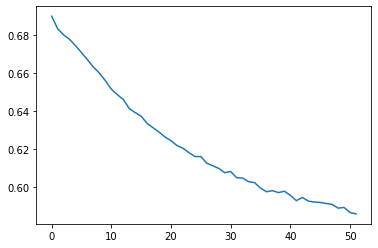

In [9]:
plt.plot([i for i in range(len(history.history["loss"]))],history.history["loss"])
plt.show()

Test losses

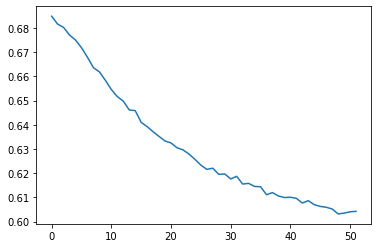

In [10]:
plt.plot([i for i in range(len(history.history['val_loss']))],history.history['val_loss'])
plt.show()

Train accuracy

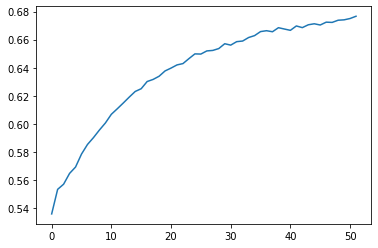

In [11]:
plt.plot([i for i in range(len(history.history['accuracy']))],history.history['accuracy'])
plt.show()

Test accuracy

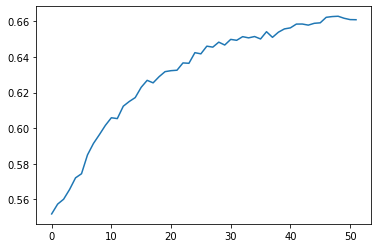

In [12]:
plt.plot([i for i in range(len(history.history['val_accuracy']))],history.history['val_accuracy'])
plt.show()

The use of early stopping is to stop further training (adjusting the weights and biases) when the loss of the validation set has no improvements for 3 epochs (with patience=3). This avoids overfitting, since if they continue to train, the train set will result in pretty good loss and acucracy, while the model cannot generalise onto the validation set.

# Q2 part a

In [13]:
X_train_cp=np.array(X_train)
Y_train_cp=np.array(y_train)

In [14]:
import time

In [15]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [16]:
batch=[128, 256, 512, 1024]

In [17]:
time_callback = TimeHistory()

In [18]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5, shuffle=True)

In [19]:
LR=0.001
EPOCH=100

In [20]:
def exp_model(input_dim):
    model=Sequential(
        [InputLayer(
    input_shape=(input_dim,)),
        Dense(128,activation='relu'),
        Dropout(0.2),
        Dense(128,activation='relu'),
        Dropout(0.2),
        Dense(128,activation='relu'),
        Dropout(0.2),
        Dense(1,activation='sigmoid')]
    )
    
    return model

In [21]:
error=[]
time_history=[]
for train,test in k_fold.split(X_train_cp,Y_train_cp):
  e=[]
  t=[]
  x_train_f,x_test_f=preprocess_dataset(X_train_cp[train],X_train_cp[test])
  y_train_f=Y_train_cp[train]
  y_test_f=Y_train_cp[test]
  for b in batch:
    model=exp_model(x_train_f.shape[1])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                    loss="binary_crossentropy",
                    metrics=['accuracy'])
    history=model.fit(x_train_f, y_train_f, verbose=0,
                          epochs=EPOCH, 
                          batch_size = b,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),time_callback], 
                          validation_data=(x_test_f,y_test_f))
    e.append(history.history['val_accuracy'][-1])
    t.append(time_callback.times[-1])
  error.append(e)
  time_history.append(t)



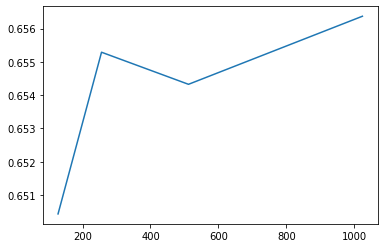

In [22]:
error_cp=np.transpose(np.array(error))
avg_error=[]
for i in error_cp:
  avg_error.append(sum(i)/len(i))

plt.plot(batch,avg_error)
plt.show()

# Q2 part b 



Shows average time for [128, 256, 512, 1024]. Average is calculated through taking the sum of training time for last epoch for 5 folds and divided by 5

In [23]:
avg_time=[]
for j in range(len(time_history[0])):
  sum_time=0
  for i in time_history:
    sum_time=sum_time+i[j]
  avg_time.append(sum_time/len(time_history))

print(avg_time)

[1.6372381687164306, 0.9674423694610595, 0.8897749423980713, 0.614406681060791]


# Q2 part c

Choose batch_size=1024. It has highest validation accuracy, and lowest time needed.

# Q2 part d

The time to train reduces, because each epochs have lower number of batches as batch size increases. So if we have fixed number of epochs (which we do, it is 100), high batch size means fewer steps taken and hence a shorter time needed.

The accuracy also increases. It means that at this learning rate, batch_size=1024 is the best for it (because usually increasing batch size will need an increase of learning rate to compensate, but might not apply to more complicated datasets)


# Q2 part e

In [24]:
BATCH_SIZE=1024
LR=0.001
EPOCH=100

In [25]:
model=Sequential(
      [InputLayer(
    input_shape=(x_train_f.shape[1],)),
      Dense(128,activation='relu'),
       Dropout(0.2),
       Dense(128,activation='relu'),
       Dropout(0.2),
       Dense(128,activation='relu'),
       Dropout(0.2),
      Dense(1,activation='sigmoid')]
  )
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  loss="binary_crossentropy",
                  metrics=['accuracy'])
history=model.fit(X_train_scaled, y_train, verbose=0,
                        epochs=EPOCH, 
                        batch_size = BATCH_SIZE,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)], 
                        validation_data=(X_test_scaled,y_test))

Train Accuracy

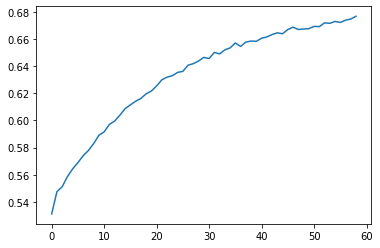

In [26]:
plt.plot([i for i in range(len(history.history['accuracy']))],history.history['accuracy'])
plt.show()

Test accuracy

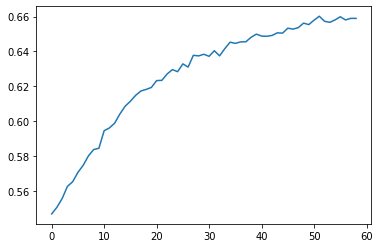

In [27]:
plt.plot([i for i in range(len(history.history['val_accuracy']))],history.history['val_accuracy'])
plt.show()

# Q3 part a

In [28]:
BATCH_SIZE=1024
LR=0.001
EPOCH=100

In [29]:
neuron_num=[64, 128, 256]
error=[]
for train,test in k_fold.split(X_train_cp,Y_train_cp):
  e=[]
  x_train_f,x_test_f=preprocess_dataset(X_train_cp[train],X_train_cp[test])
  y_train_f=Y_train_cp[train]
  y_test_f=Y_train_cp[test]

  for n in neuron_num:
    model=exp_model(x_train_f.shape[1])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                    loss="binary_crossentropy",
                    metrics=['accuracy'])
    history=model.fit(x_train_f, y_train_f, verbose=0,
                          epochs=EPOCH, 
                          batch_size = BATCH_SIZE,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)], 
                          validation_data=(x_test_f,y_test_f))
    e.append(history.history['val_accuracy'][-1])
  error.append(e)

In [30]:
error_cp=np.transpose(np.array(error))
avg_error=[]
for i in error_cp:
  avg_error.append(sum(i)/len(i))

print(avg_error)

[0.6522100687026977, 0.6525235652923584, 0.6537777066230774]


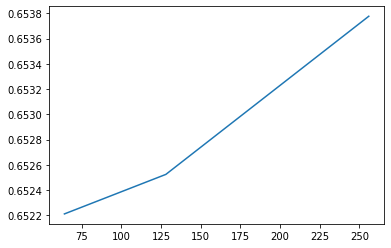

In [31]:
plt.plot([64, 128, 256],avg_error)
plt.show()

# Q3 part b

choose 256 since the accuracy is the highest.

# Q3 part c

In [32]:
BATCH_SIZE=1024
LR=0.001
EPOCH=100
NEURON_NUM=256

In [33]:
model=Sequential(
      [
        InputLayer(
    input_shape=(x_train_f.shape[1],)),
      Dense(NEURON_NUM,activation='relu'),
       Dropout(0.2),
       Dense(128,activation='relu'),
       Dropout(0.2),
       Dense(128,activation='relu'),
       Dropout(0.2),
      Dense(1,activation='sigmoid')]
  )
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  loss="binary_crossentropy",
                  metrics=['accuracy'])
history=model.fit(X_train_scaled, y_train, verbose=0,
                        epochs=EPOCH, 
                        batch_size = BATCH_SIZE,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)], 
                        validation_data=(X_test_scaled,y_test))

Train accuracy

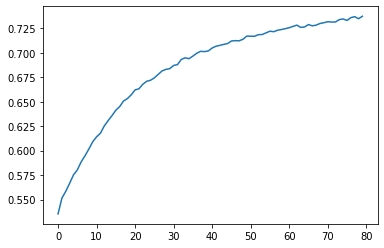

In [34]:
plt.plot([i for i in range(len(history.history['accuracy']))],history.history['accuracy'])
plt.show()

Test accuracy

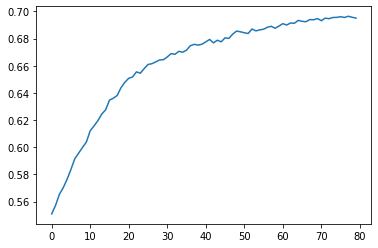

In [35]:
plt.plot([i for i in range(len(history.history['val_accuracy']))],history.history['val_accuracy'])
plt.show()

# Q3 part d

Drop out: randomly selects some neurons to ignore during training (decided by probability p). During testing, the weights are not ignored, instead of multiplied by p. So, during test time, the output is expected output.

It works because not all neurons are trained together at all times, thus preventing co-adapting and reduces possibility of overfitting.

# Q3 part e

Regularization of weights.

It adds a penalty to cost function. In this case I use L2 regularization, which is the sum of squares of each weight element in weight matrix. The sum of squares is multiplied by a factor and it is added to the cost function. Then after differentiation with respect to W, the amount to minus from original weight will become learning_rate x(original gradient + decay_parameter x W). It prevents the weights to get too large and cause over fitting.

In [36]:
from tensorflow.keras import regularizers

In [37]:
BATCH_SIZE=1024
LR=0.001
EPOCH=100
NEURON_NUM=256

In [38]:
model_reg=Sequential(
      [
      Dense(NEURON_NUM,activation='relu',kernel_regularizer=regularizers.L2(0.001)),
       Dropout(0.2),
       Dense(128,activation='relu',kernel_regularizer=regularizers.L2(0.001)),
       Dropout(0.2),
       Dense(128,activation='relu',kernel_regularizer=regularizers.L2(0.001)),
       Dropout(0.2),
      Dense(1,activation='sigmoid')]
  )
model_reg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
history_reg=model_reg.fit(X_train_scaled, y_train, verbose=0,
                        epochs=EPOCH, 
                        batch_size = BATCH_SIZE,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)], 
                        validation_data=(X_test_scaled,y_test))

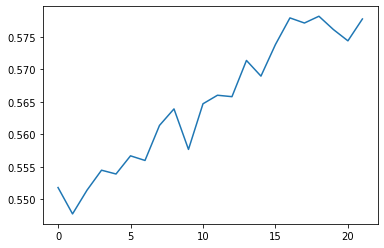

In [39]:
plt.plot([i for i in range(len(history_reg.history['val_accuracy']))],history_reg.history['val_accuracy'])
plt.show()

It seems that the regularizer penalty is too large! There is not much overfitting in the original model, so applying a regularizer does not really help.

# Q4 part a

In [40]:
df_new = pd.read_csv('new_record.csv') 
df_new=df_new.drop(['filename'],axis=1)

In [41]:
df_new

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,135.999178,1046,95.090909,0.451505,0.089929,0.51699,0.071409,0.273657,0.008445,0.031216,...,-13.075774,168.34549,-12.533779,97.71234,-4.375724,60.67439,-10.928949,85.53412,-3.784146,121.532646


In [42]:
standard_scaler = preprocessing.StandardScaler()
df_new_scaled = standard_scaler.fit_transform(df_new)

In [43]:

sound_to_predict=np.array(df_new_scaled)

# Q4 part b

In [44]:
BATCH_SIZE=1024
LR=0.001
EPOCH=100
NEURON_NUM=256

model=Sequential(
      [
        InputLayer(
    input_shape=(x_train_f.shape[1],)),
      Dense(NEURON_NUM,activation='relu'),
       Dropout(0.2),
       Dense(128,activation='relu'),
       Dropout(0.2),
       Dense(128,activation='relu'),
       Dropout(0.2),
      Dense(1,activation='sigmoid')]
  )
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  loss="binary_crossentropy",
                  metrics=['accuracy'])
history=model.fit(X_train_scaled, y_train, verbose=0,
                        epochs=EPOCH, 
                        batch_size = BATCH_SIZE,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)], 
                        validation_data=(X_test_scaled,y_test))

In [45]:
result=model.predict(sound_to_predict)
print(result)

1/1 [==============================] - 0s 71ms/step
[[0.6480622]]


It is correct as the first sample is recorded in a slightly positive manner

# Q4 part c

In [46]:
import shap

C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 1000, replace=False)]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(sound_to_predict)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Most important feature:

In [48]:
shap.initjs()

In [49]:
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0], features=np.reshape(np.array(df_new.iloc[0]),[1,77]), feature_names=df_new.columns)

In [60]:
df_new.columns[np.argmax(np.abs(shap_values[0][0]))]

'mfcc5_mean'

mfcc is the most important feature probably because it captures the amplitude vs frequency in sound. When people are positive, they might stress some sound with a particular frequency, and that is captured by the model and used to predict the attitude.

# Conclusion

The data is originally from a wavefront type of data, and time plays an important role. It might be better to use a recurrent neural entwork for such tasks as it takes into the consideration of time, unlike this one, which is only considering the average/variance of features across all time.

The most important parameter is neuron number, for it boosts test accuracy by slightly more than batch_size. It is probably because having more neurons provide a closer fit to the data, and thus captures the inner relationship better.

This modelling might also be used to detect more fine-grained emotions from sound (e.g. happiness, sadness, fear etc). The pipeline remains about the same, use the various indicators to extract the features from the sound, and in the end the neural network will output probability for each of the emotion classes available in the target dataset.

